# Overview of this jupyter notebook

1. Loading data
2. Transforming data (normalization, shuffle)
3. Training the CAE
4. Searching optimal threshold with validation data
5. Evaluation of the CAE with test data and optimized threshold
6. Plot train, test and each reconstructed data

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
import pickle
import json

In [6]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization, UpSampling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import autokeras as ak
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
import os
import importlib
from library import etl_data as etl             # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc         # this module contains the color combination of FAPS Institute
from library import classification_util as cu   # this module contains helper functions for the classification task
from library import autoencoder_util as au      # this module contains helper functions for the anomalie detection task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(cu))
print(importlib.reload(au))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\classification_util.py'>
<module 'library.autoencoder_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\autoencoder_util.py'>


## 1. Loading data

In [8]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [9]:
df0 = pd.read_pickle("dataframes/df0_v4.1.pkl")
df1 = pd.read_pickle("dataframes/df1_v4.1.pkl")
df2 = pd.read_pickle("dataframes/df2_v4.1.pkl")
df3 = pd.read_pickle("dataframes/df3_v4.1.pkl")
df4 = pd.read_pickle("dataframes/df4_v4.1.pkl")
df5 = pd.read_pickle("dataframes/df5_v4.1.pkl")
df6 = pd.read_pickle("dataframes/df6_v4.1.pkl")
df7 = pd.read_pickle("dataframes/df7_v4.1.pkl")

In [10]:
df0.shape

(775, 800)

In [11]:
# important for searching misclassified curves in each df

df_list = [df0, df1, df2, df3, df4, df5, df6, df7]

In [12]:
# train data is already mixed through shuffle in jupyter notebook "B_Data_Preparation_Autoencoder"
train_data = np.load('feature_label/train_data_autoencoder_v3.npy')
train_data.shape

(600, 920)

In [13]:
test_data = np.load('feature_label/test_data_autoencoder_v3.npy')
test_data.shape

(380, 920)

In [14]:
val_data = np.load('feature_label/val_data_autoencoder_v3.npy')
val_data.shape

(380, 920)

In [15]:
test_label = np.load('feature_label/test_data_label_autoencoder_v3.npy')
test_label.shape

(380,)

In [16]:
val_label = np.load('feature_label/val_data_label_autoencoder_v3.npy')
val_label.shape

(380,)

## 2. Transforming data (normalization, shuffle)

In [17]:
x_train = train_data
x_train.shape

(600, 920)

In [18]:
# shuffle the test data 

x_test, y_test = shuffle(test_data, test_label, random_state=1)

In [19]:
# shuffle the validation data 

x_val, y_val = shuffle(val_data, val_label, random_state=1)

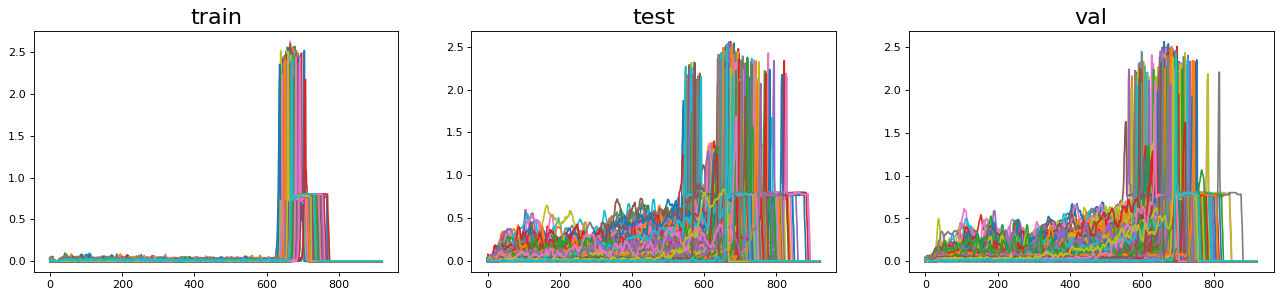

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train.transpose())
axs[1].plot(x_test.transpose())
axs[2].plot(x_val.transpose())

axs[0].set_title("train", fontsize=20)
axs[1].set_title("test", fontsize=20)
axs[2].set_title("val", fontsize=20)
fig.show()

In [21]:
y_test

array([4, 3, 5, 3, 4, 6, 1, 3, 1, 6, 4, 6, 4, 4, 0, 3, 1, 0, 0, 1, 7, 6,
       7, 2, 0, 1, 4, 1, 4, 0, 5, 1, 7, 0, 4, 7, 0, 6, 7, 2, 6, 5, 0, 1,
       5, 2, 4, 0, 7, 2, 0, 0, 0, 7, 0, 7, 6, 1, 1, 3, 2, 6, 0, 4, 1, 0,
       0, 5, 0, 6, 4, 6, 6, 2, 3, 3, 6, 7, 5, 0, 7, 7, 0, 5, 0, 0, 1, 0,
       0, 5, 6, 6, 4, 6, 0, 5, 5, 3, 6, 0, 0, 5, 4, 0, 7, 7, 5, 0, 0, 0,
       3, 2, 4, 2, 7, 4, 7, 6, 3, 1, 0, 0, 4, 6, 1, 6, 4, 2, 0, 2, 1, 1,
       0, 1, 0, 3, 0, 2, 0, 1, 6, 6, 0, 0, 2, 7, 2, 0, 3, 4, 3, 2, 7, 5,
       2, 2, 2, 1, 0, 1, 4, 1, 7, 2, 0, 7, 2, 5, 0, 4, 3, 4, 1, 6, 2, 0,
       7, 4, 0, 3, 0, 6, 6, 6, 0, 0, 0, 7, 0, 5, 0, 6, 5, 0, 4, 0, 5, 0,
       2, 1, 0, 0, 4, 7, 3, 7, 7, 6, 0, 3, 2, 6, 0, 1, 2, 5, 0, 0, 1, 2,
       0, 0, 3, 5, 1, 0, 6, 3, 3, 3, 1, 5, 1, 3, 7, 2, 6, 3, 4, 4, 5, 3,
       0, 0, 5, 5, 7, 0, 3, 0, 1, 7, 7, 4, 6, 5, 1, 5, 2, 6, 0, 2, 3, 3,
       3, 1, 4, 1, 5, 0, 0, 3, 2, 2, 3, 2, 0, 5, 0, 3, 4, 0, 5, 0, 7, 0,
       7, 0, 3, 0, 5, 7, 2, 6, 0, 0, 5, 4, 4, 3, 2,

In [22]:
y_val

array([4, 3, 5, 3, 4, 6, 1, 3, 1, 6, 4, 6, 4, 4, 0, 3, 1, 0, 0, 1, 7, 6,
       7, 2, 0, 1, 4, 1, 4, 0, 5, 1, 7, 0, 4, 7, 0, 6, 7, 2, 6, 5, 0, 1,
       5, 2, 4, 0, 7, 2, 0, 0, 0, 7, 0, 7, 6, 1, 1, 3, 2, 6, 0, 4, 1, 0,
       0, 5, 0, 6, 4, 6, 6, 2, 3, 3, 6, 7, 5, 0, 7, 7, 0, 5, 0, 0, 1, 0,
       0, 5, 6, 6, 4, 6, 0, 5, 5, 3, 6, 0, 0, 5, 4, 0, 7, 7, 5, 0, 0, 0,
       3, 2, 4, 2, 7, 4, 7, 6, 3, 1, 0, 0, 4, 6, 1, 6, 4, 2, 0, 2, 1, 1,
       0, 1, 0, 3, 0, 2, 0, 1, 6, 6, 0, 0, 2, 7, 2, 0, 3, 4, 3, 2, 7, 5,
       2, 2, 2, 1, 0, 1, 4, 1, 7, 2, 0, 7, 2, 5, 0, 4, 3, 4, 1, 6, 2, 0,
       7, 4, 0, 3, 0, 6, 6, 6, 0, 0, 0, 7, 0, 5, 0, 6, 5, 0, 4, 0, 5, 0,
       2, 1, 0, 0, 4, 7, 3, 7, 7, 6, 0, 3, 2, 6, 0, 1, 2, 5, 0, 0, 1, 2,
       0, 0, 3, 5, 1, 0, 6, 3, 3, 3, 1, 5, 1, 3, 7, 2, 6, 3, 4, 4, 5, 3,
       0, 0, 5, 5, 7, 0, 3, 0, 1, 7, 7, 4, 6, 5, 1, 5, 2, 6, 0, 2, 3, 3,
       3, 1, 4, 1, 5, 0, 0, 3, 2, 2, 3, 2, 0, 5, 0, 3, 4, 0, 5, 0, 7, 0,
       7, 0, 3, 0, 5, 7, 2, 6, 0, 0, 5, 4, 4, 3, 2,

In [23]:
# normalize data by dividing through np.max(x_train)

max_train = np.max(x_train)
x_train_scaled = x_train / max_train
x_test_scaled = x_test / max_train
x_val_scaled = x_val / max_train

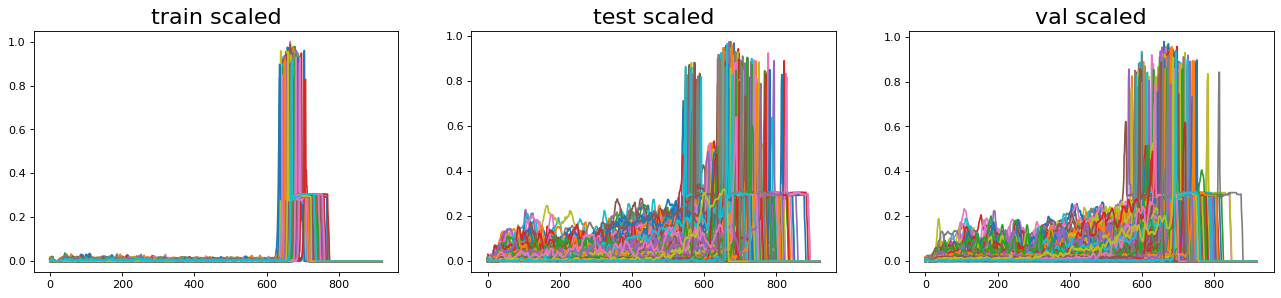

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_scaled.transpose())
axs[1].plot(x_test_scaled.transpose())
axs[2].plot(x_val_scaled.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("test scaled", fontsize=20)
axs[2].set_title("val scaled", fontsize=20)
fig.show()

In [25]:
x_train_inverse = x_train_scaled * max_train
x_test_inverse = x_test_scaled * max_train
x_val_inverse = x_val_scaled * max_train

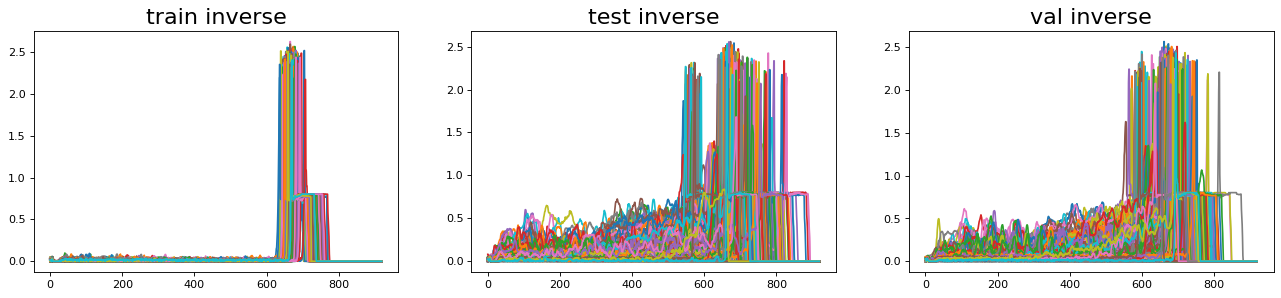

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_inverse.transpose())
axs[1].plot(x_test_inverse.transpose())
axs[2].plot(x_val_inverse.transpose())

axs[0].set_title("train inverse", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
axs[2].set_title("val inverse", fontsize=20)
fig.show()

In [27]:
# check, whether the inverse data is equal to original data

np.array_equal(np.round(x_train, 4), np.round(x_train_inverse, 4))

True

In [28]:
# reshape train and test data in 3 dim data for CNN AutoEncoder
len_curve = 920

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)
x_val = x_val.reshape(-1, len_curve, 1)

x_train_scaled = x_train_scaled.reshape(-1, len_curve, 1)
x_test_scaled = x_test_scaled.reshape(-1, len_curve, 1)
x_val_scaled = x_val_scaled.reshape(-1, len_curve, 1)

## 3. Training the CAE

In [125]:
def cae():
    model = Sequential()
    # encoder network
    model.add(Conv1D(32, 8, activation= 'relu', padding='same', input_shape = (len_curve, 1)))
    model.add(MaxPooling1D(2, padding= 'same'))
    model.add(Conv1D(32, 8, activation= 'relu', padding='same'))
    model.add(MaxPooling1D(2, padding= 'same'))
    model.add(Conv1D(32, 8, activation= 'relu', padding='same'))
    model.add(MaxPooling1D(2, padding= 'same'))

    #decoder network
    model.add(Conv1D(32, 8, activation= 'relu', padding='same'))
    model.add(UpSampling1D(2))
    model.add(Conv1D(32, 8, activation= 'relu', padding='same'))
    model.add(UpSampling1D(2))
    model.add(Conv1D(32, 8, activation= 'relu', padding='same'))
    model.add(UpSampling1D(2))
    model.add(Conv1D(1, 3, activation='sigmoid', padding= 'same')) # output layer

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["mae"])
    
    return model

In [126]:
model = cae()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 920, 32)           288       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 460, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 460, 32)           8224      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 230, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 230, 32)           8224      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 115, 32)         

In [127]:
epochs = 40
batch_size = 10

In [128]:
history = model.fit(x_train_scaled, x_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor="val_loss", patience=int(epochs*0.2), verbose=1)])

Epoch 1/40
48/48 [==============================] - 6s 33ms/step - loss: 0.2262 - mae: 0.1180 - val_loss: 0.0671 - val_mae: 0.0102
Epoch 2/40
48/48 [==============================] - 1s 26ms/step - loss: 0.0663 - mae: 0.0085 - val_loss: 0.0629 - val_mae: 0.0067
Epoch 3/40
48/48 [==============================] - 1s 30ms/step - loss: 0.0635 - mae: 0.0057 - val_loss: 0.0616 - val_mae: 0.0051
Epoch 4/40
48/48 [==============================] - 1s 26ms/step - loss: 0.0624 - mae: 0.0044 - val_loss: 0.0606 - val_mae: 0.0041
Epoch 5/40
48/48 [==============================] - 1s 27ms/step - loss: 0.0617 - mae: 0.0037 - val_loss: 0.0602 - val_mae: 0.0032
Epoch 6/40
48/48 [==============================] - 1s 26ms/step - loss: 0.0615 - mae: 0.0033 - val_loss: 0.0600 - val_mae: 0.0031
Epoch 7/40
48/48 [==============================] - 1s 26ms/step - loss: 0.0614 - mae: 0.0032 - val_loss: 0.0600 - val_mae: 0.0029
Epoch 8/40
48/48 [==============================] - 1s 26ms/step - loss: 0.0613 - m

In [167]:
#model.save("model/cnn_autoencoder_v3.1.1.h5")

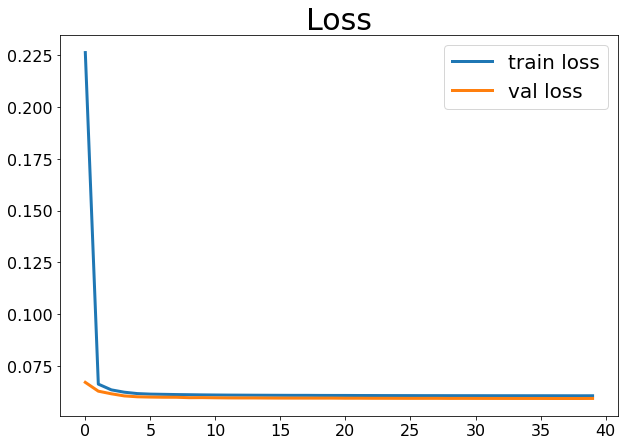

In [129]:
cu.plot_loss(history)

In [29]:
loaded_model =  tf.keras.models.load_model('model/cnn_autoencoder_v3.1.1.h5')
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 920, 32)           288       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 460, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 460, 32)           8224      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 230, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 230, 32)           8224      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 115, 32)         

##  4. Searching optimal threshold with validation data

In [30]:
y_val

array([4, 3, 5, 3, 4, 6, 1, 3, 1, 6, 4, 6, 4, 4, 0, 3, 1, 0, 0, 1, 7, 6,
       7, 2, 0, 1, 4, 1, 4, 0, 5, 1, 7, 0, 4, 7, 0, 6, 7, 2, 6, 5, 0, 1,
       5, 2, 4, 0, 7, 2, 0, 0, 0, 7, 0, 7, 6, 1, 1, 3, 2, 6, 0, 4, 1, 0,
       0, 5, 0, 6, 4, 6, 6, 2, 3, 3, 6, 7, 5, 0, 7, 7, 0, 5, 0, 0, 1, 0,
       0, 5, 6, 6, 4, 6, 0, 5, 5, 3, 6, 0, 0, 5, 4, 0, 7, 7, 5, 0, 0, 0,
       3, 2, 4, 2, 7, 4, 7, 6, 3, 1, 0, 0, 4, 6, 1, 6, 4, 2, 0, 2, 1, 1,
       0, 1, 0, 3, 0, 2, 0, 1, 6, 6, 0, 0, 2, 7, 2, 0, 3, 4, 3, 2, 7, 5,
       2, 2, 2, 1, 0, 1, 4, 1, 7, 2, 0, 7, 2, 5, 0, 4, 3, 4, 1, 6, 2, 0,
       7, 4, 0, 3, 0, 6, 6, 6, 0, 0, 0, 7, 0, 5, 0, 6, 5, 0, 4, 0, 5, 0,
       2, 1, 0, 0, 4, 7, 3, 7, 7, 6, 0, 3, 2, 6, 0, 1, 2, 5, 0, 0, 1, 2,
       0, 0, 3, 5, 1, 0, 6, 3, 3, 3, 1, 5, 1, 3, 7, 2, 6, 3, 4, 4, 5, 3,
       0, 0, 5, 5, 7, 0, 3, 0, 1, 7, 7, 4, 6, 5, 1, 5, 2, 6, 0, 2, 3, 3,
       3, 1, 4, 1, 5, 0, 0, 3, 2, 2, 3, 2, 0, 5, 0, 3, 4, 0, 5, 0, 7, 0,
       7, 0, 3, 0, 5, 7, 2, 6, 0, 0, 5, 4, 4, 3, 2,

In [31]:
# transform labels that bigger than 0 into 1s
y_val_binary = y_val.copy()
y_val_binary[y_val_binary>0] = 1
y_val_binary

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

In [32]:
reconstructed_train_inverse, reconstructed_val_inverse = au.prepare_train_test(loaded_model, x_train_scaled, x_val_scaled, 
                                                                               max_train, len_curve=x_train.shape[1], 
                                                                               scaled=True)

reconstructed_train_inverse shape: (600, 920)
reconstructed_test_inverse shape: (380, 920)


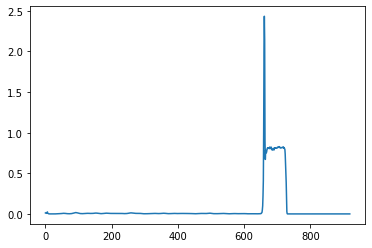

In [33]:
plt.plot(reconstructed_train_inverse[0])

In [34]:
# calculate reconstruction loss with mean absolute error
train_mae, val_mae = au.reconstruction_loss_mae(x_train_inverse, reconstructed_train_inverse,
                                                x_val_inverse, reconstructed_val_inverse)

In [35]:
max(train_mae)

0.010152039778472711

In [36]:
from library import autoencoder_util as au
print(importlib.reload(au))

<module 'library.autoencoder_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\autoencoder_util.py'>


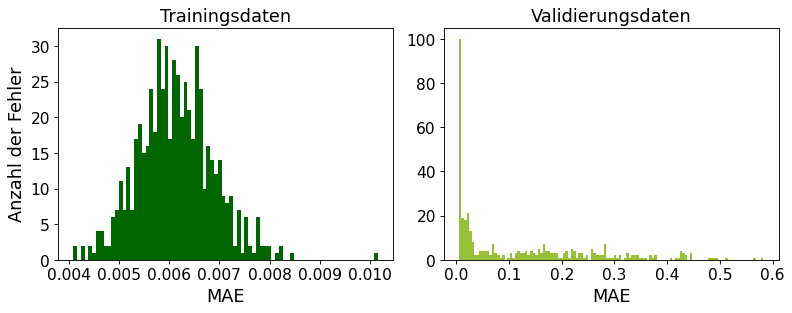

In [58]:
au.plot_error_hist(train_error=train_mae, test_error=val_mae, error_type="mae", bin_num1=80, bin_num2=120, val=True,
                   figsize=(10,4), dpi=80)

In [38]:
start = 0.0
end = 0.02
steps = 0.0005

In [39]:
val_threshold = {"threshold": [], "tpr": [], "fpr": [], "f1": [], "acc": []}

for i in np.arange(start, end, steps):
    val_threshold["threshold"].append(i)
    tpr, fpr, f1, acc = au.get_predictions(y_val_binary, threshold=i, loss=val_mae)
    val_threshold["tpr"].append(tpr)
    val_threshold["fpr"].append(fpr)
    val_threshold["f1"].append(f1)
    val_threshold["acc"].append(acc)
    

In [40]:
val_threshold

{'threshold': [0.0,
  0.0005,
  0.001,
  0.0015,
  0.002,
  0.0025,
  0.003,
  0.0035,
  0.004,
  0.0045000000000000005,
  0.005,
  0.0055,
  0.006,
  0.006500000000000001,
  0.007,
  0.0075,
  0.008,
  0.0085,
  0.009000000000000001,
  0.0095,
  0.01,
  0.0105,
  0.011,
  0.0115,
  0.012,
  0.0125,
  0.013000000000000001,
  0.0135,
  0.014,
  0.0145,
  0.015,
  0.0155,
  0.016,
  0.0165,
  0.017,
  0.0175,
  0.018000000000000002,
  0.0185,
  0.019,
  0.0195],
 'tpr': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.02,
  0.19,
  0.5,
  0.75,
  0.92,
  0.96,
  0.98,
  0.99,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'fpr': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0035714285714285713,
  0.014285714285714285,
  0.014285714285714285,
  0.0321428571428571

In [41]:
df_threshold = pd.DataFrame(val_threshold)
df_threshold

,threshold,tpr,fpr,f1,acc
0,0.0000,0.00,0.000000,0.848485,0.736842
1,0.0005,0.00,0.000000,0.848485,0.736842
2,0.0010,0.00,0.000000,0.848485,0.736842
3,0.0015,0.00,0.000000,0.848485,0.736842
4,0.0020,0.00,0.000000,0.848485,0.736842
5,0.0025,0.00,0.000000,0.848485,0.736842
6,0.0030,0.00,0.000000,0.848485,0.736842
7,0.0035,0.00,0.000000,0.848485,0.736842
8,0.0040,0.00,0.000000,0.848485,0.736842
9,0.0045,0.00,0.000000,0.848485,0.736842


In [42]:
# optimal threshold is 0.009 or 0.0095
df_threshold[df_threshold.f1==1]

,threshold,tpr,fpr,f1,acc
18,0.0090,1.0,0.0,1.0,1.0
19,0.0095,1.0,0.0,1.0,1.0


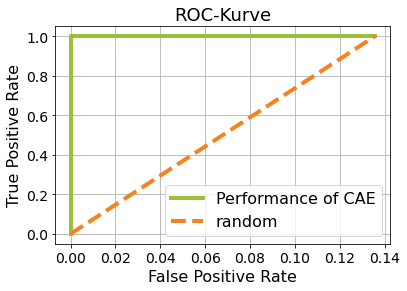

In [43]:
plt.figure(figsize=(6,4))
plt.plot(val_threshold["fpr"], val_threshold["tpr"], color=fapsc.green, linewidth=4, label="Performance of CAE")
plt.plot([0, df_threshold["fpr"].iloc[-1]], [0, 1], color=fapsc.orange, linewidth=4, linestyle="--", label="random")

plt.xlabel("False Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("True Positive Rate", fontsize=16)
plt.yticks(fontsize=14)
plt.title("ROC-Kurve", fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid()
plt.show()

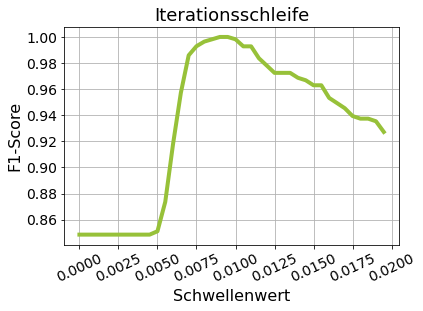

In [44]:
plt.figure(figsize=(6,4))
plt.plot(val_threshold["threshold"], val_threshold["f1"], linewidth=4, color=fapsc.green)
plt.xlabel("Schwellenwert", fontsize=16)
plt.ylabel("F1-Score", fontsize=16)
plt.xticks(fontsize=14, rotation=25)
plt.yticks(fontsize=14)
plt.title("Iterationsschleife", fontsize=18)
plt.grid()
plt.show()

## 5. Evaluation of the CAE with test data and optimized threshold

In [45]:
y_test_binary = y_test.copy()
y_test_binary[y_test_binary>0] = 1
y_test_binary

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

In [47]:
reconstructed_train_inverse, reconstructed_test_inverse = au.prepare_train_test(loaded_model, x_train_scaled, x_test_scaled, 
                                                                               max_train, len_curve=x_train.shape[1], 
                                                                               scaled=True)

reconstructed_train_inverse shape: (600, 920)
reconstructed_test_inverse shape: (380, 920)


In [48]:
train_mae, test_mae = au.reconstruction_loss_mae(x_train_inverse, reconstructed_train_inverse,
                                                 x_test_inverse, reconstructed_test_inverse)

In [49]:
anomaly_prediction = au.get_anomaly_pred_acc(y_test_binary, threshold=0.009, loss=test_mae)
anomaly_prediction

Accuracy: 1.0
Recall: 1.0
F1 Score: 1.0


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

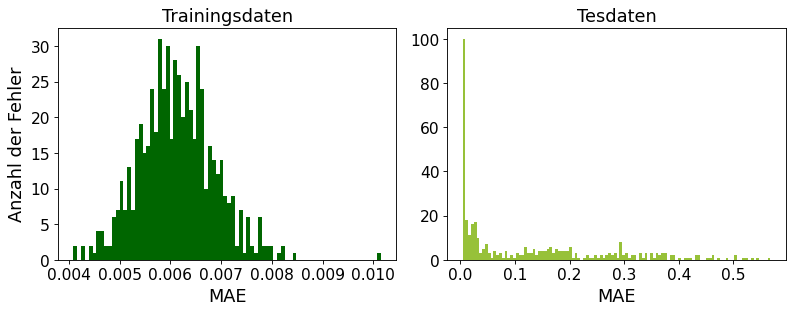

In [50]:
au.plot_error_hist(train_error=train_mae, test_error=test_mae, error_type="mae", bin_num1=80, bin_num2=110, val=False,
                   figsize=(10,4), dpi=80)

In [63]:
from library import autoencoder_util as au
print(importlib.reload(au))

<module 'library.autoencoder_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\autoencoder_util.py'>


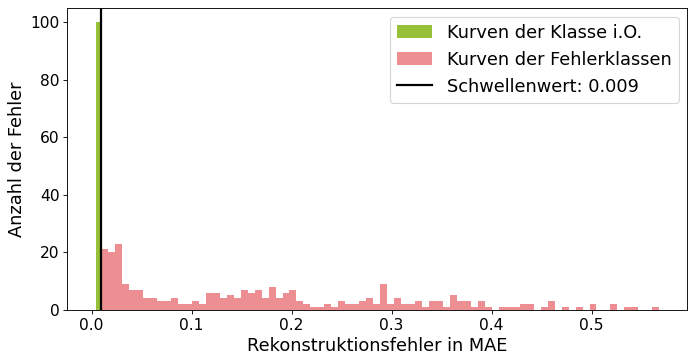

In [66]:
au.plot_clean_fraud(y_test=y_test, test_error=test_mae, bin_num0=1, bin_num1=80, threshold=0.009, error_type="mae",
                    figsize=(10,5), dpi=80)

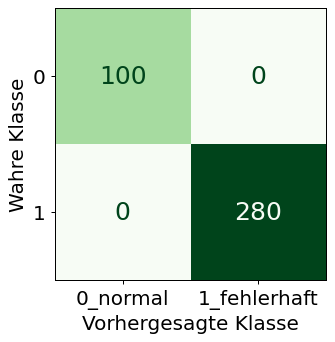

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       280

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380



In [68]:
au.plot_calc_cm_binary(y_test_binary, anomaly_prediction, figsize=(4,4), dpi=90)

In [200]:
anomaly_prediction_converted = []

for i, val in enumerate(zip(anomaly_prediction, y_test)):
    if val[0] == 0:
        anomaly_prediction_converted.append(0)
    elif (val[0] > 0) & (val[1] > 0):
        anomaly_prediction_converted.append(val[1])
    elif (val[0] == 1) & (val[1] == 0):
        anomaly_prediction_converted.append(val[0])

anomaly_prediction_converted = np.array(anomaly_prediction_converted)
anomaly_prediction_converted

array([4, 3, 5, 3, 4, 6, 1, 3, 1, 6, 4, 6, 4, 4, 0, 3, 1, 0, 0, 1, 7, 6,
       7, 2, 0, 1, 4, 1, 4, 0, 5, 1, 7, 0, 4, 7, 0, 6, 7, 2, 6, 5, 0, 1,
       5, 2, 4, 0, 7, 2, 0, 0, 0, 7, 0, 7, 6, 1, 1, 3, 2, 6, 0, 4, 1, 0,
       0, 5, 0, 6, 4, 6, 6, 2, 3, 3, 6, 7, 5, 0, 7, 7, 0, 5, 0, 0, 1, 0,
       0, 5, 6, 6, 4, 6, 0, 5, 5, 3, 6, 0, 0, 5, 4, 0, 7, 7, 5, 0, 0, 0,
       3, 2, 4, 2, 7, 4, 7, 6, 3, 1, 0, 0, 4, 6, 1, 6, 4, 2, 0, 2, 1, 1,
       0, 1, 0, 3, 0, 2, 0, 1, 6, 6, 0, 0, 2, 7, 2, 0, 3, 4, 3, 2, 7, 5,
       2, 2, 2, 1, 0, 1, 4, 1, 7, 2, 0, 7, 2, 5, 0, 4, 3, 4, 1, 6, 2, 0,
       7, 4, 0, 3, 0, 6, 6, 6, 0, 0, 0, 7, 0, 5, 0, 6, 5, 0, 4, 0, 5, 0,
       2, 1, 0, 0, 4, 7, 3, 7, 7, 6, 0, 3, 2, 6, 0, 1, 2, 5, 0, 0, 1, 2,
       0, 0, 3, 5, 1, 0, 6, 3, 3, 3, 1, 5, 1, 3, 7, 2, 6, 3, 4, 4, 5, 3,
       0, 0, 5, 5, 7, 0, 3, 0, 1, 7, 7, 4, 6, 5, 1, 5, 2, 6, 0, 2, 3, 3,
       3, 1, 4, 1, 5, 0, 0, 3, 2, 2, 3, 2, 0, 5, 0, 3, 4, 0, 5, 0, 7, 0,
       7, 0, 3, 0, 5, 7, 2, 6, 0, 0, 5, 4, 4, 3, 2,

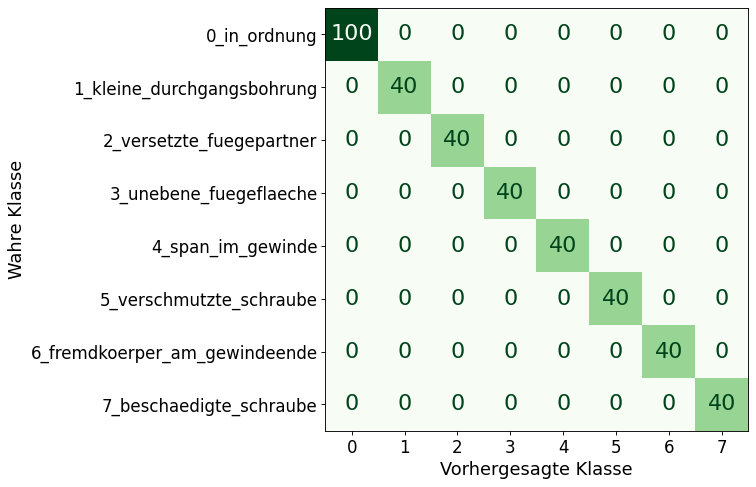

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380



In [201]:
au.plot_calc_cm(y_test, anomaly_prediction_converted, classes)

## 6. plot train, test and each reconstructed data

In [66]:
reconstructed_train, reconstructed_test = au.prepare_train_test(loaded_model, x_train_scaled, x_test_scaled, 
                                                                max_train, len_curve=x_train.shape[1], 
                                                                scaled=False)

(600, 920)
(380, 920)


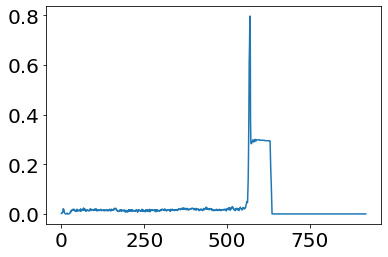

In [81]:
plt.plot(x_test_scaled[7])

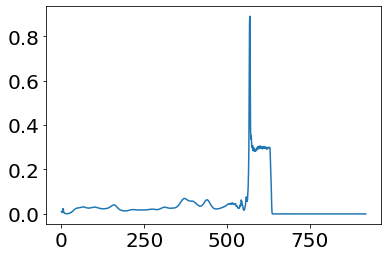

In [82]:
plt.plot(reconstructed_test[7])

In [159]:
y_test

array([4, 3, 5, 3, 4, 6, 1, 3, 1, 6, 4, 6, 4, 4, 0, 3, 1, 0, 0, 1, 7, 6,
       7, 2, 0, 1, 4, 1, 4, 0, 5, 1, 7, 0, 4, 7, 0, 6, 7, 2, 6, 5, 0, 1,
       5, 2, 4, 0, 7, 2, 0, 0, 0, 7, 0, 7, 6, 1, 1, 3, 2, 6, 0, 4, 1, 0,
       0, 5, 0, 6, 4, 6, 6, 2, 3, 3, 6, 7, 5, 0, 7, 7, 0, 5, 0, 0, 1, 0,
       0, 5, 6, 6, 4, 6, 0, 5, 5, 3, 6, 0, 0, 5, 4, 0, 7, 7, 5, 0, 0, 0,
       3, 2, 4, 2, 7, 4, 7, 6, 3, 1, 0, 0, 4, 6, 1, 6, 4, 2, 0, 2, 1, 1,
       0, 1, 0, 3, 0, 2, 0, 1, 6, 6, 0, 0, 2, 7, 2, 0, 3, 4, 3, 2, 7, 5,
       2, 2, 2, 1, 0, 1, 4, 1, 7, 2, 0, 7, 2, 5, 0, 4, 3, 4, 1, 6, 2, 0,
       7, 4, 0, 3, 0, 6, 6, 6, 0, 0, 0, 7, 0, 5, 0, 6, 5, 0, 4, 0, 5, 0,
       2, 1, 0, 0, 4, 7, 3, 7, 7, 6, 0, 3, 2, 6, 0, 1, 2, 5, 0, 0, 1, 2,
       0, 0, 3, 5, 1, 0, 6, 3, 3, 3, 1, 5, 1, 3, 7, 2, 6, 3, 4, 4, 5, 3,
       0, 0, 5, 5, 7, 0, 3, 0, 1, 7, 7, 4, 6, 5, 1, 5, 2, 6, 0, 2, 3, 3,
       3, 1, 4, 1, 5, 0, 0, 3, 2, 2, 3, 2, 0, 5, 0, 3, 4, 0, 5, 0, 7, 0,
       7, 0, 3, 0, 5, 7, 2, 6, 0, 0, 5, 4, 4, 3, 2,

In [235]:
def plot_original_recon(original_curve, reconstructed_curve, classes, color, figsize=(10, 2.8), title=False, xlabel=False):
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    axs[0].plot(etl.set_time(original_curve), original_curve, color=color, linewidth=4, label=classes)
    axs[0].set_ylim(0, 1.1)
    #axs[0].set_ylabel("Normiertes Drehmoment in Nm", fontsize=16)
    if xlabel:
        axs[0].set_xlabel("Zeit in Sekunden", fontsize=16)
    if title:
        axs[0].set_title("Originale Kurve", fontsize=18, pad=10)
    axs[0].legend(loc='upper left', fontsize=16)
    axs[0].tick_params(axis='both', labelsize=15)
    axs[0].grid()
    
    axs[1].plot(etl.set_time(reconstructed_curve), reconstructed_curve, color=color, linewidth=4)
    axs[1].set_ylim(0, 1.1)
    if xlabel:
        axs[1].set_xlabel("Zeit in Sekunden", fontsize=16)
    if title:
        axs[1].set_title("Rekonstruierte Kurve", fontsize=18, pad=10)
    axs[1].tick_params(axis='both', labelsize=15)
    axs[1].grid()
    
    fig.tight_layout(pad=1)
    fig.show()

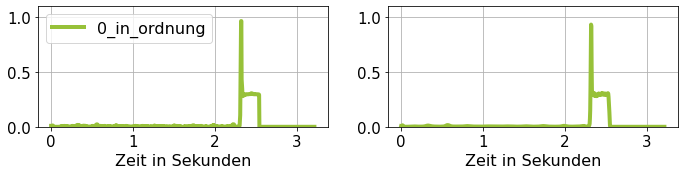

In [236]:
plot_original_recon(x_test_scaled[-1], reconstructed_test[-1], classes[0], fapsc.green, xlabel=True)

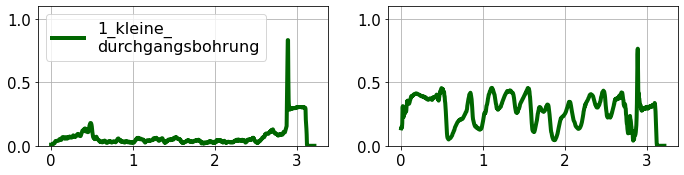

In [239]:
plot_original_recon(x_test_scaled[6], reconstructed_test[6], f"1_kleine_\ndurchgangsbohrung", fapsc.dark_green)

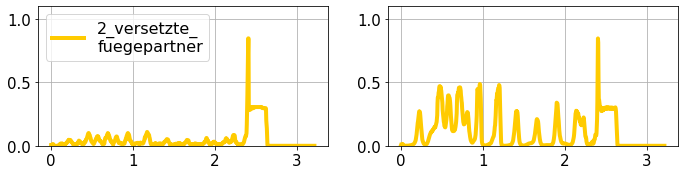

In [240]:
plot_original_recon(x_test_scaled[-8], reconstructed_test[-8], f"2_versetzte_\nfuegepartner", fapsc.yellow)

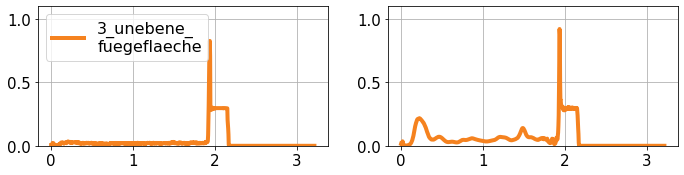

In [243]:
plot_original_recon(x_test_scaled[1], reconstructed_test[1], f"3_unebene_\nfuegeflaeche", fapsc.orange)

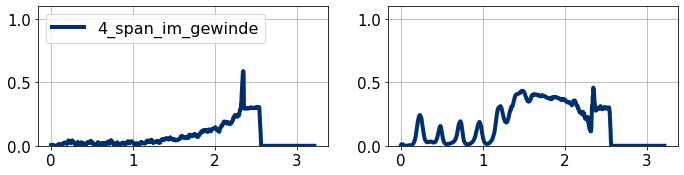

In [244]:
plot_original_recon(x_test_scaled[0], reconstructed_test[0], classes[4], fapsc.blue)

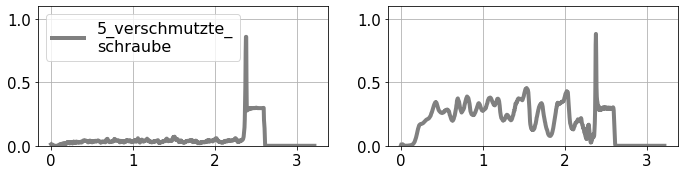

In [247]:
plot_original_recon(x_test_scaled[2], reconstructed_test[2], f"5_verschmutzte_\nschraube", fapsc.grey_0)

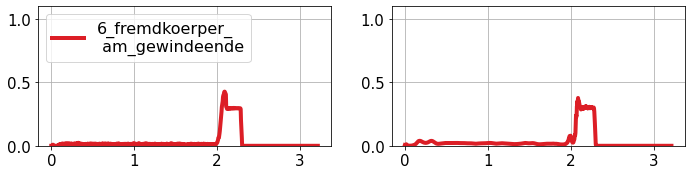

In [252]:
plot_original_recon(x_test_scaled[5], reconstructed_test[5], f"6_fremdkoerper_\n am_gewindeende", fapsc.red, figsize=(10.1, 2.8))

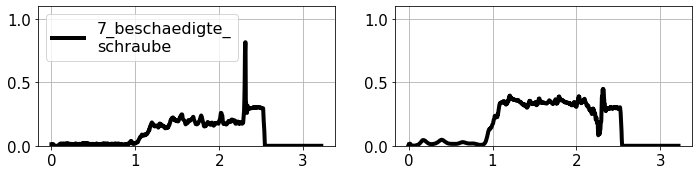

In [253]:
plot_original_recon(x_test_scaled[20], reconstructed_test[20], f"7_beschaedigte_\nschraube", fapsc.black, figsize=(10.2, 2.8))